In [4]:
!pip install pyspark

# Análise de dados de cartão de crédito

Este notebook tem como objetivo realizar uma Análise Exploratória de Dados (EDA) em um conjunto de transações financeiras associadas a cartões de crédito. A intenção é compreender o comportamento dos dados antes de aplicar técnicas de Detecção de Anomalias com PySpark e Inteligência Artificial.

In [5]:
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
spark = SparkSession.builder.appName('credicard_analysis').getOrCreate()

In [7]:
df_transactions = spark.read.csv('/content/drive/MyDrive/files_for_projects/credicard_analysis/transactions.csv', header=True, inferSchema=True)
df_info = spark.read.csv('/content/drive/MyDrive/files_for_projects/credicard_analysis/cc_info.csv', header=True, inferSchema=True)

In [8]:
# Exploração incial do Dataframe
df_transactions.show(3)
df_info.show(3)


+----------------+-------------------+-------------------------+-----------------+----------------+
|     credit_card|               date|transaction_dollar_amount|             Long|             Lat|
+----------------+-------------------+-------------------------+-----------------+----------------+
|1003715054175576|2015-09-11 00:32:40|                    43.78|-80.1741323292432|40.2673703430082|
|1003715054175576|2015-10-24 22:23:08|                   103.15|-80.1942395924575|40.1801138227341|
|1003715054175576|2015-10-26 18:19:36|                    48.55|-80.2110325106832| 40.313004401402|
+----------------+-------------------+-------------------------+-----------------+----------------+
only showing top 3 rows

+----------------+-------+-----+-------+-----------------+
|     credit_card|   city|state|zipcode|credit_card_limit|
+----------------+-------+-----+-------+-----------------+
|1280981422329509| Dallas|   PA|  18612|             6000|
|9737219864179988|Houston|   PA|  15342

In [9]:
# Detecção de dados duplicados df_tansacitons

print('Total de transações: ', df_transactions.count())

transactions_unique = df_transactions.dropDuplicates()
print('Total transações unicas: ', transactions_unique.count())


# Detecção de dados duplicados df_info
print('Total de info ', df_info.count())

info_unique = df_info.dropDuplicates()
print('Total info unicas: ', info_unique.count())

Total de transações:  294588
Total transações unicas:  294588
Total de info  984
Total info unicas:  984


Não foram indenficados registros duplicados nos dois Dataframes.


In [10]:
from pyspark.sql.functions import *

df_transactions.select([count(when(col(c).isNull(), c)).alias(c) for c in df_transactions.columns]).show()
df_info.select([count(when(col(c).isNull(), c)).alias(c) for c in df_info.columns]).show()

+-----------+----+-------------------------+----+---+
|credit_card|date|transaction_dollar_amount|Long|Lat|
+-----------+----+-------------------------+----+---+
|          0|   0|                        0|   0|  0|
+-----------+----+-------------------------+----+---+

+-----------+----+-----+-------+-----------------+
|credit_card|city|state|zipcode|credit_card_limit|
+-----------+----+-----+-------+-----------------+
|          0|   0|    0|      0|                0|
+-----------+----+-----+-------+-----------------+



Não foram indenficados registros nulos nos dois Dataframes.

In [85]:
# Juntar os dois dataframes
df_transactions_join = df_transactions.join(df_info, on = 'credit_card', how = 'Left')

df_transactions_join.show(3)

+----------------+-------------------+-------------------------+-----------------+----------------+-------+-----+-------+-----------------+
|     credit_card|               date|transaction_dollar_amount|             Long|             Lat|   city|state|zipcode|credit_card_limit|
+----------------+-------------------+-------------------------+-----------------+----------------+-------+-----+-------+-----------------+
|1003715054175576|2015-09-11 00:32:40|                    43.78|-80.1741323292432|40.2673703430082|Houston|   PA|  15342|            20000|
|1003715054175576|2015-10-24 22:23:08|                   103.15|-80.1942395924575|40.1801138227341|Houston|   PA|  15342|            20000|
|1003715054175576|2015-10-26 18:19:36|                    48.55|-80.2110325106832| 40.313004401402|Houston|   PA|  15342|            20000|
+----------------+-------------------+-------------------------+-----------------+----------------+-------+-----+-------+-----------------+
only showing top 3 r

In [86]:
# Validação de informações
print('Quantidade de cartões: ', df_transactions_join.select('credit_card').distinct().count())
print('Quantidade de Transações: ', df_transactions_join.select('credit_card').count())

Quantidade de cartões:  984
Quantidade de Transações:  294588


## Importação dos Dados

Nesta etapa, os arquivos contendo informações de transações e limites de crédito por cliente foram carregados utilizando PySpark. Também foi realizada uma verificação inicial para identificar dados duplicados ou ausentes (nulos), o que é fundamental para garantir a qualidade da análise.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Converte o DataFrame PySpark para pandas
df_pd = df_transactions_join.toPandas()

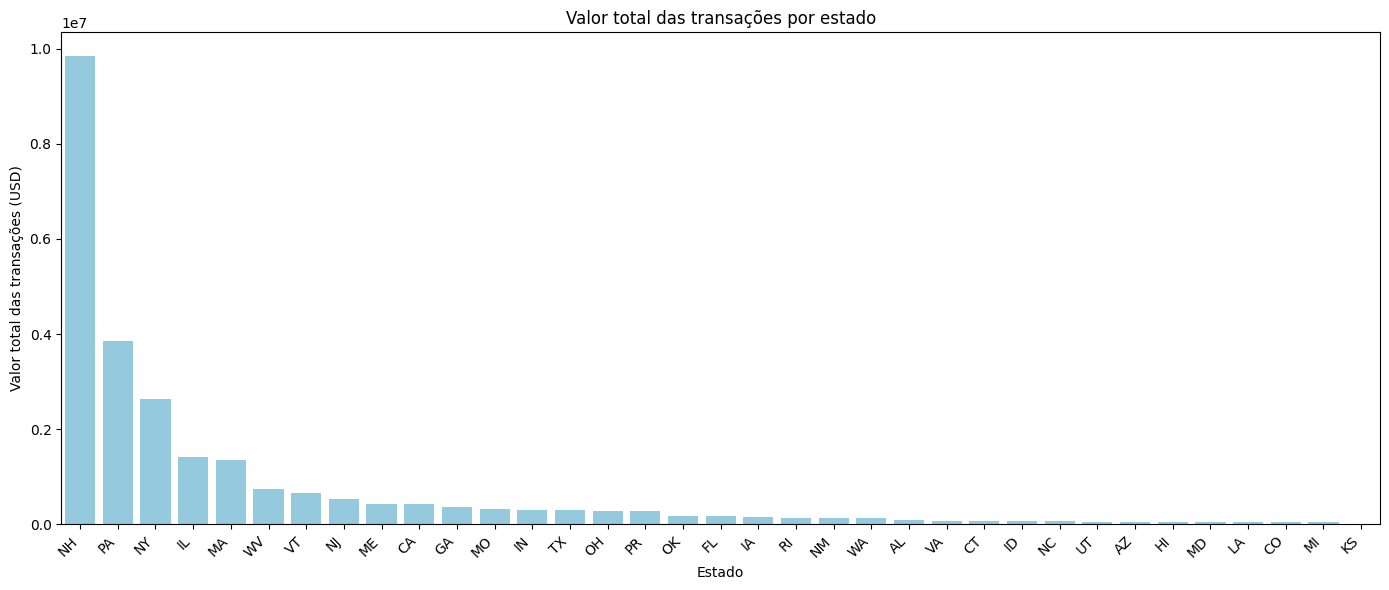

In [43]:
# Soma valores por estado e coloca em ordem descrescente
state_group = df_pd.groupby('state')['transaction_dollar_amount'].sum().sort_values(ascending=False).reset_index()

# Representação gráfica do estados com maior volume de transação
plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='transaction_dollar_amount', data=state_group, color='skyblue')
plt.xlabel('Estado')
plt.ylabel('Valor total das transações (USD)')
plt.title('Valor total das transações por estado')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [56]:
# Calcula o percetual do volução de transações realizadas dos 3 estados que mais se destacam
NH_percent = (df_pd[df_pd['state'] == "NH"]['transaction_dollar_amount'].sum() / df_pd['transaction_dollar_amount'].sum())*100
PA_percent = (df_pd[df_pd['state'] == "PA"]['transaction_dollar_amount'].sum() / df_pd['transaction_dollar_amount'].sum())*100
NY_percent = (df_pd[df_pd['state'] == "NY"]['transaction_dollar_amount'].sum() / df_pd['transaction_dollar_amount'].sum())*100

print('Volume de transações em Nova Hampshire (NH): ', NH_percent)
print('Volume de transações em Pensilvânia (PA): ', PA_percent)
print('Volume de transações em Nova York (NY): ', NY_percent)


Volume de transações em Nova Hampshire (NH):  38.882961928983654
Volume de transações em Pensilvânia (PA):  15.185667348207655
Volume de transações em Nova York (NY):  10.419269349235138


Os gráfico demonstra o maior valor de transações se concentra no estado de Noova Hampshire, que corresponde a 38,88 % do valor total das transações. Seguida vem o estado da Pensilvânia, com 15,19 % da valores das transaçõe e Nova York com apenas 10.42 % dos valor da transações. Evidênciando a dispariade do estado Nova Hampshire com os demais estado, ao quis respeito ao valor total de transações.

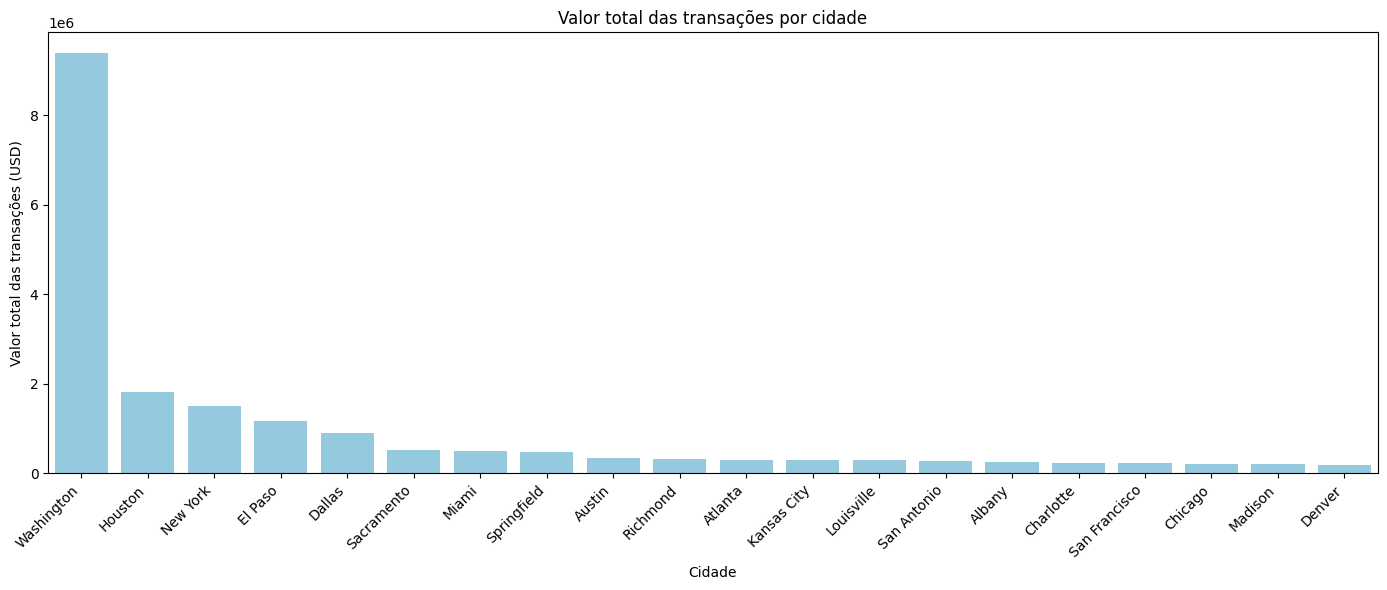

In [59]:
# Soma valores por cidade e coloca em ordem descrescente
city_group = df_pd.groupby('city')['transaction_dollar_amount'].sum().sort_values(ascending=False).reset_index()

# Seleciona apenas as 20 cidades com maior volume, para facilitar leitura do gráfico
top_20_cities = city_group.head(20)

# Representação gráfica das 20 cidades com maior volume de transação
plt.figure(figsize=(14, 6))
sns.barplot(x='city', y='transaction_dollar_amount', data=top_20_cities, color='skyblue')
plt.xlabel('Cidade')
plt.ylabel('Valor total das transações (USD)')
plt.title('Valor total das transações por cidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [63]:
# Calcula o percetual do volução de transações realizadas das 3 cidades que mais se destacam
Washingthon_percent = (df_pd[df_pd['city'] == "Washington"]['transaction_dollar_amount'].sum() / df_pd['transaction_dollar_amount'].sum())*100
Hoyston_percent = (df_pd[df_pd['city'] == "Houston"]['transaction_dollar_amount'].sum() / df_pd['transaction_dollar_amount'].sum())*100
New_York_percent = (df_pd[df_pd['city'] == "New York"]['transaction_dollar_amount'].sum() / df_pd['transaction_dollar_amount'].sum())*100

print('Volume de transações em Washingthon: ', Washingthon_percent)
print('Volume de transações em Hoyston: ', Hoyston_percent)
print('Volume de transações em Nova York : ', New_York_percent)

Volume de transações em Washingthon:  37.056455947006846
Volume de transações em Hoyston:  7.142888531251318
Volume de transações em Nova York :  5.908340407906381


Os gráfico demonstra o maior valor de transações se concentra na cidade deWashingthon, que corresponde a 37,06 % do valor total das transações. Seguida vem a cidade de Houston, com 7,14 % da valores das transaçõe e Nova York com apenas 5,90 % dos valor da transações.

Text(0.5, 1.0, 'Correlação entre Variáveis')

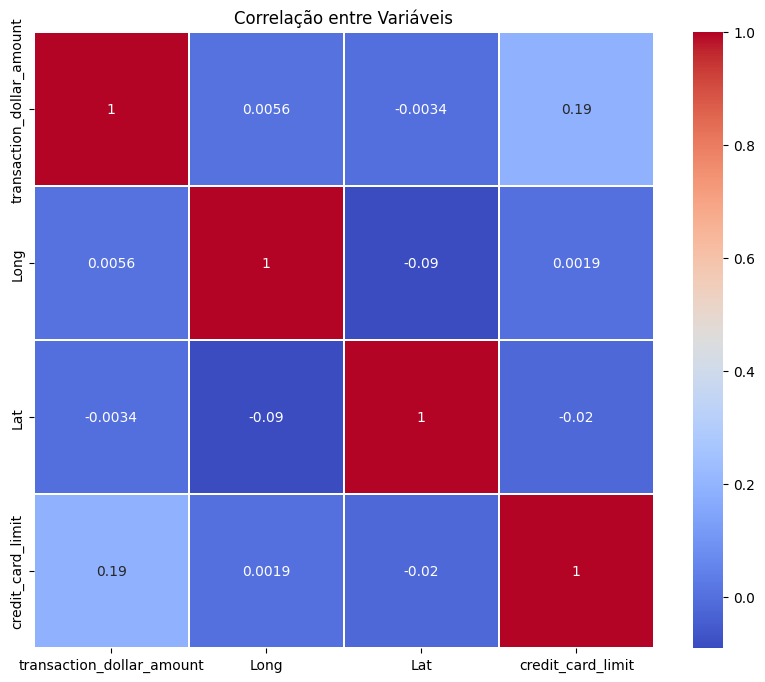

In [67]:
corr = df_pd[['transaction_dollar_amount', 'Long',  'Lat', 'credit_card_limit']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm',linewidths=0.1)
plt.title('Correlação entre Variáveis')

A correlação entre as variáveis númericas é insignificante

Text(0.5, 1.0, 'Correlação entre Variáveis')

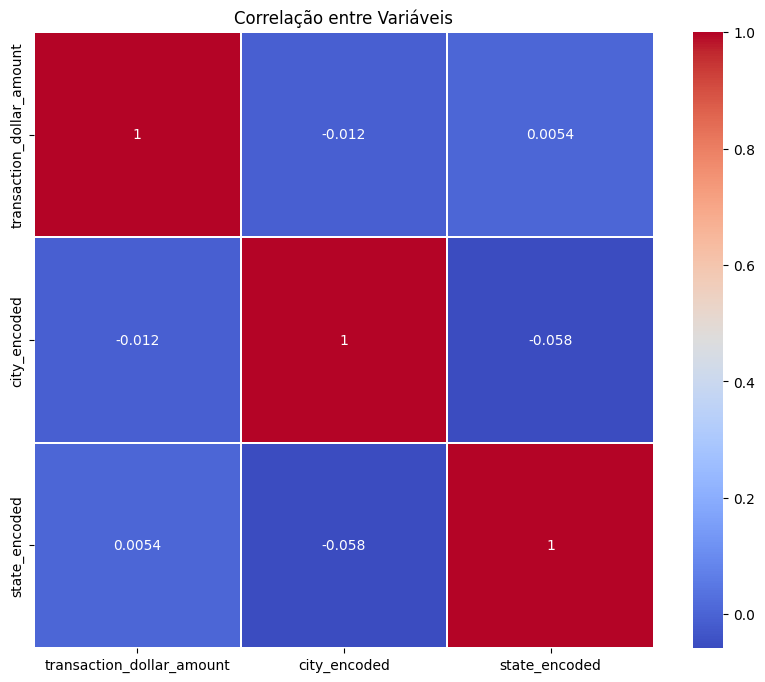

In [84]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_pd['city_encoded'] = le.fit_transform(df_pd['city'])
df_pd['state_encoded'] = le.fit_transform(df_pd['state'])

corr2 = df_pd[['transaction_dollar_amount', 'city_encoded','state_encoded']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr2, annot=True, cmap='coolwarm',linewidths=0.1)
plt.title('Correlação entre Variáveis')


A correlação entre as variáveis categorias também é insignificante

Text(0.5, 1.0, 'Relação entre Valor da Transação e Limite de Crédito')

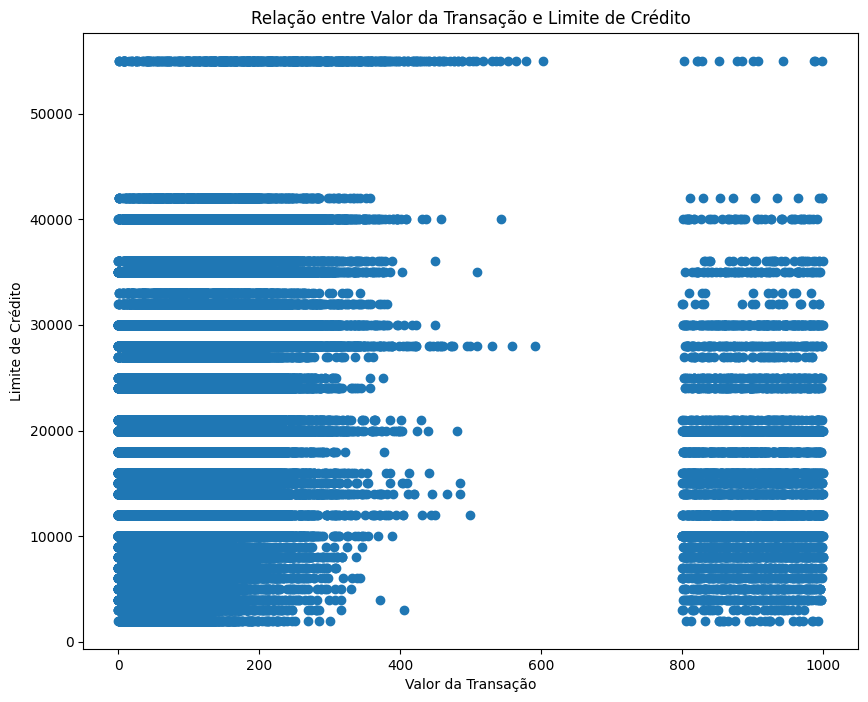

In [68]:
# Dispersão entre limite e valor da transação
plt.figure(figsize=(10,8))
plt.scatter(df_pd['transaction_dollar_amount'], df_pd['credit_card_limit'])
plt.xlabel('Valor da Transação')
plt.ylabel('Limite de Crédito')
plt.title('Relação entre Valor da Transação e Limite de Crédito')

Os tem um grande volume de transações com valores abaixo de R$ 200,00, mesmo com limites bem mais altos.

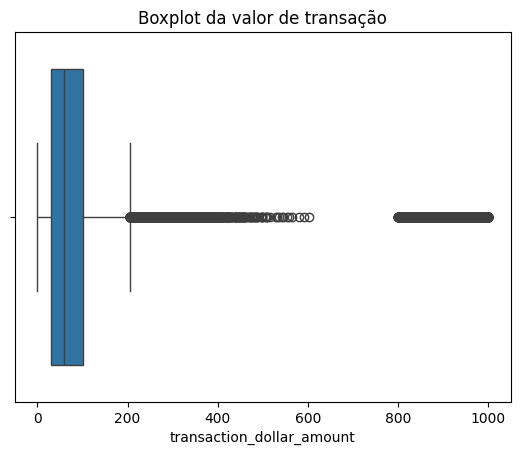

In [69]:
#vericando se outliers
sns.boxplot(x=df_pd['transaction_dollar_amount'])
plt.title('Boxplot da valor de transação')
plt.show()

Confirma o resultado do grafico de dispersão, que os valores de transação estão concentrados em valores abaixo de R$ 200,00.

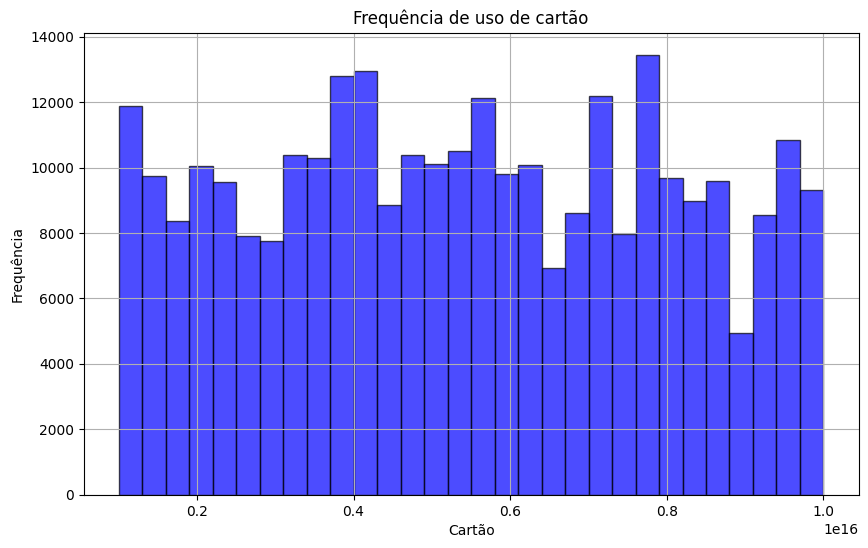

In [70]:
# Histograma com frequência do uso de cartão
plt.figure(figsize=(10,6))
plt.hist(df_pd['credit_card'], bins=30, color="blue", alpha=0.7, edgecolor='black')
plt.title('Frequência de uso de cartão')
plt.xlabel('Cartão')
plt.ylabel('Frequência')
plt.grid(True)

Não foi identificada nenhum anomalia referente a frequencia no uso do cartão.

Principal achado: a empresa precisa rever a politica de limite dado aos clientes, existe um disparidade entre limite fornecido e valor usado